# Ising model 2D

## Introduction

We use in this Jupyter Notebook the `2D-Ising-Model-Package` python package to check that the basic expected properties of the two-dimensional Ising model are well predicted.
In our simple model, the Ising model deals with an square array of spins that interact with coupling constant $J$ with their nearest neighbours in an external field $h$ with the following hamiltonian:
$$
\mathcal{H}(\{\sigma\}) = - J \sum_{\langle i, j \rangle} \sigma_i \sigma_j + h \sum_i \sigma_i
$$
We decided to look at the behavior of the average magnetization per site and the energy of the system in various regimes.

## Package installation

The package that was used can be found [on GitHub](https://github.com/stephen70/2D-Ising-Model-Package), but the version I use is slightly modified and can be found on [this fork](https://github.com/alexandrejourneaux/2D-Ising-Model-Package). It was cloned in the virtual machine via ssh. And can be installed thanks to pip by uncommenting and running this line:

In [5]:
#!pip install -e ~/2D-Ising-Model-Package

Let us import the package for later use, as well as a few other useful ones.

In [6]:
import ising2D
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Influence of the number of simulation steps

In [ ]:
steps = 10**np.arange(7)
energies = []
magnetizations = []

for ii, num_step in enumerate(steps):
    
    model = ising2D.IsingSquare(50, interactionVal=0, magMoment=1)
    
    model.basicIter(iters=num_step, temp=1, plot=False)
    energies.append(model.totalEnergy())
    magnetizations.append(model.totalMag())
    print(model.totalEnergy())

In [ ]:
plt.plot(steps, energies)
plt.xscale("log")

In [ ]:
plt.plot(steps, magnetizations)
plt.xscale("log")

## Paramagnetic-ferromagnetic transition

We start by qualitatively observing the well-known phase transition between the ferromagnetic and paramagnetic phases at zero magnetic field. The theoretical $T_c$ for a 2-dimensional lattice is at $T_c / J = 2.269$, so we take here $J = 1$. We can see no long-range order on the spin configurations for $T = 4$ and $3$, and it is clear that the up-down symmetry is broken on broader areas for $T=2$ and $T=1$.

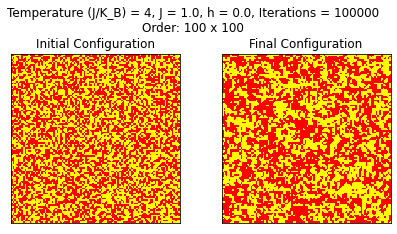

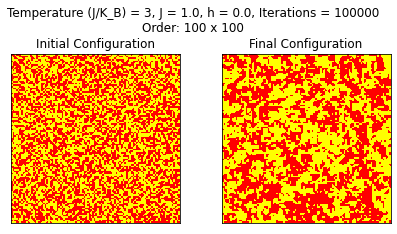

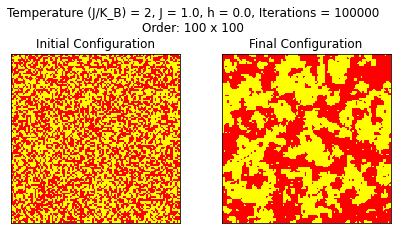

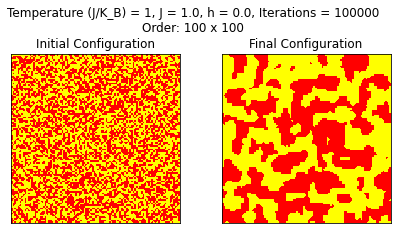

In [7]:
model = ising2D.IsingSquare(100, interactionVal=1, magMoment=0)

for temp in [4, 3, 2, 1]:
    model.basicIter(iters=100000,
                    temp=temp,
                    plot=True)

## No interactions, with various magnetic fields

We can now plot macroscopic quantities of interest, averaged on 1000 Monte Carlo iterations (this value is fixed in the code). Let us start with a very simple case (we can easily solve it analytically) where there are no interactions between the spins, but an non zero applied magnetic field.


In [7]:
N_mag = 3


magFields = np.linspace(0.5, 1.5, N_mag, endpoint=True)
result_dicts = []

for ii, magField in enumerate(magFields):
    
    model = ising2D.IsingSquare(50, interactionVal=0, magMoment=magField)
    
    result_dicts.append(
        model.tempRangeIter(
            tempRange=np.linspace(0.1, 8, 50),
            itersPerTemp=1e5,
            plotProperties=False
        )
    )

100%|██████████| 50/50 [19:11<00:00, 23.03s/it]


We store the results in a csv file for future use.

In [8]:
for i, d in enumerate(result_dicts):
    df = pd.DataFrame.from_dict(d, orient="index")
    df.to_csv(f"result_dicts_{i}.csv")

In [9]:
read_csv = True
N_mag = 3

if read_csv:
    result_dicts = []
    for i in range(N_mag):
        df = pd.read_csv(f"result_dicts_{i}.csv", index_col=0)
        d = df.to_dict("split")
        result_dicts.append(dict(zip(d["index"], d["data"])))

Blabla magnétisation

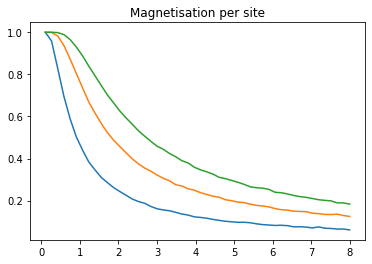

In [10]:
for ii in range(3):
    plt.figure(1)
    plt.plot(result_dicts[ii]["tempRange"], result_dicts[ii]["magList"])
    plt.title("Magnetisation per site")

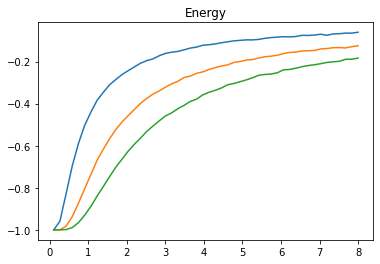

In [11]:
for ii in range(3):
    plt.figure(1)
    plt.plot(result_dicts[ii]["tempRange"], result_dicts[ii]["energyList"])
    plt.title("Energy")

## No magnetic field, with various interactions

In [ ]:
N_int = 3

interactions = np.linspace(0.1, 1, N_int, endpoint=True)
result_dicts2 = []

for ii, interaction in enumerate(interactions):
    
    model = ising2D.IsingSquare(50, interactionVal=interaction, magMoment=0)
    
    result_dicts2.append(
        model.tempRangeIter(
            tempRange=np.linspace(0.1, 8, 50),
            itersPerTemp=1e5,
            plotProperties=False
        )
    )

 20%|██        | 10/50 [03:50<15:19, 22.98s/it]

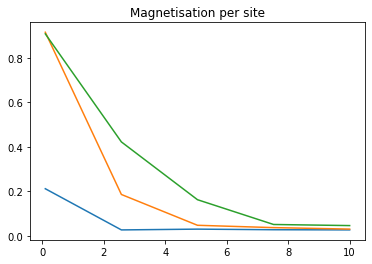

In [27]:
for ii in range(3):
    plt.figure(1)
    plt.plot(result_dicts2[ii]["tempRange"], result_dicts2[ii]["magList"])
    plt.title("Magnetisation per site")

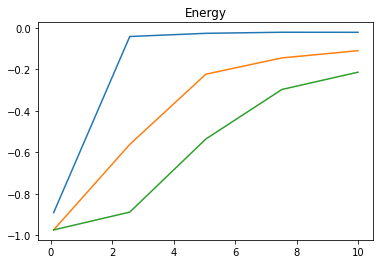

In [28]:
for ii in range(3):
    plt.figure(1)
    plt.plot(result_dicts2[ii]["tempRange"], result_dicts2[ii]["energyList"])
    plt.title("Energy")

## Observation of the non-analyticity of $M(T)$ in the termodynamic limit

In [ ]:
spins = 10**np.arange(4)
result_dicts3 = []

for ii, N_spin in enumerate(spins):
    
    model = ising2D.IsingSquare(N_spins, interactionVal=1, magMoment=0)
    
    result_dicts3.append(
        model.tempRangeIter(
            tempRange=np.linspace(0.1, 10, 5),
            itersPerTemp=100,
            plotProperties=False
        )
    )